# Agentic Sales Pipeline 💼

## Introduction 
In this notebook, we will explore the `creation of an agentic sales pipeline using CrewAI`. This involves setting up agents, tasks, and crews for lead qualification and email engagement. We will utilize YAML files for configuration and employ Pydantic models for structured data handling. Additionally, we will visualize the sales pipeline flow and kick off the entire process.

### Initial Imports

In [1]:
%pip install "crewai[tools]"
%pip install "crewai[all]"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
from helper import load_env
load_env()

import os
import yaml
from crewai import Agent, Task, Crew

### Load API tokens 

In [3]:
os.environ['OPENAI_MODEL_NAME'] = 'gpt-4o-mini'

### Loading Tasks and Agents YAML files

In [4]:
# Define file paths for YAML configurations
files = {
    'lead_agents': 'config/lead_qualification_agents.yaml',
    'lead_tasks': 'config/lead_qualification_tasks.yaml',
    'email_agents': 'config/email_engagement_agents.yaml',
    'email_tasks': 'config/email_engagement_tasks.yaml'
}

# Load configurations from YAML files
configs = {}
for config_type, file_path in files.items():
    with open(file_path, 'r') as file:
        configs[config_type] = yaml.safe_load(file)

# Assign loaded configurations to specific variables
lead_agents_config = configs['lead_agents']
lead_tasks_config = configs['lead_tasks']
email_agents_config = configs['email_agents']
email_tasks_config = configs['email_tasks']

### Create Pydantic Models for Structured Output

In [5]:
from pydantic import BaseModel, Field
from typing import Dict, Optional, List, Set, Tuple

class LeadPersonalInfo(BaseModel):
    name: str = Field(..., description="The full name of the lead.")
    job_title: str = Field(..., description="The job title of the lead.")
    role_relevance: int = Field(..., ge=0, le=10, description="A score representing how relevant the lead's role is to the decision-making process (0-10).")
    professional_background: Optional[str] = Field(..., description="A brief description of the lead's professional background.")

class CompanyInfo(BaseModel):
    company_name: str = Field(..., description="The name of the company the lead works for.")
    industry: str = Field(..., description="The industry in which the company operates.")
    company_size: int = Field(..., description="The size of the company in terms of employee count.")
    revenue: Optional[float] = Field(None, description="The annual revenue of the company, if available.")
    market_presence: int = Field(..., ge=0, le=10, description="A score representing the company's market presence (0-10).")

class LeadScore(BaseModel):
    score: int = Field(..., ge=0, le=100, description="The final score assigned to the lead (0-100).")
    scoring_criteria: List[str] = Field(..., description="The criteria used to determine the lead's score.")
    validation_notes: Optional[str] = Field(None, description="Any notes regarding the validation of the lead score.")

class LeadScoringResult(BaseModel):
    personal_info: LeadPersonalInfo = Field(..., description="Personal information about the lead.")
    company_info: CompanyInfo = Field(..., description="Information about the lead's company.")
    lead_score: LeadScore = Field(..., description="The calculated score and related information for the lead.")

### Importing Tools

In [6]:
import os
from crewai import Agent, Task, Crew
# Importing crewAI tools
from crewai_tools import (
    SerperDevTool,
    ScrapeWebsiteTool
    #WebsiteSearchTool
)

from helper import get_openai_api_key, get_serper_api_key
# Set up API keys
os.environ["OPENAI_API_KEY"] = get_openai_api_key()
os.environ["SERPER_API_KEY"] = get_serper_api_key()

# Instantiate tools
search_tool = SerperDevTool()
scrape_tool = ScrapeWebsiteTool()

c:\Users\Michela\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\_internal\_config.py:295: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)
c:\Users\Michela\AppData\Local\Programs\Python\Python312\Lib\site-packages\crewai_tools\tools\scrapegraph_scrape_tool\scrapegraph_scrape_tool.py:34: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  @validator("website_url")
c:\Users\Michela\AppData\Local\Programs\Python\Python312\Lib\site-packages\crewai_tools\tools\selen

### Lead Qualification Crew, Agents and Tasks

- Creating Agents, Creating Tasks, Creating Crew

In [7]:
# Creating Agents
lead_data_agent = Agent(
  config=lead_agents_config['lead_data_agent'],
  tools=[SerperDevTool(), ScrapeWebsiteTool()]
)

cultural_fit_agent = Agent(
  config=lead_agents_config['cultural_fit_agent'],
  tools=[SerperDevTool(), ScrapeWebsiteTool()]
)

scoring_validation_agent = Agent(
  config=lead_agents_config['scoring_validation_agent'],
  tools=[SerperDevTool(), ScrapeWebsiteTool()]
)

# Creating Tasks
lead_data_task = Task(
  config=lead_tasks_config['lead_data_collection'],
  agent=lead_data_agent
)

cultural_fit_task = Task(
  config=lead_tasks_config['cultural_fit_analysis'],
  agent=cultural_fit_agent
)

scoring_validation_task = Task(
  config=lead_tasks_config['lead_scoring_and_validation'],
  agent=scoring_validation_agent,
  context=[lead_data_task, cultural_fit_task],
  output_pydantic=LeadScoringResult
)

# Creating Crew
lead_scoring_crew = Crew(
  agents=[
    lead_data_agent,
    cultural_fit_agent,
    scoring_validation_agent
  ],
  tasks=[
    lead_data_task,
    cultural_fit_task,
    scoring_validation_task
  ],
  verbose=True
)

### Email Engagement Crew

In [8]:
# Creating Agents
email_content_specialist = Agent(
  config=email_agents_config['email_content_specialist']
)

engagement_strategist = Agent(
  config=email_agents_config['engagement_strategist']
)

# Creating Tasks
email_drafting = Task(
  config=email_tasks_config['email_drafting'],
  agent=email_content_specialist
)

engagement_optimization = Task(
  config=email_tasks_config['engagement_optimization'],
  agent=engagement_strategist
)

# Creating Crew
email_writing_crew = Crew(
  agents=[
    email_content_specialist,
    engagement_strategist
  ],
  tasks=[
    email_drafting,
    engagement_optimization
  ],
  verbose=True
)

2025-02-26 18:45:22,055 - 11928 - __init__.py-__init__:537 - WARNING: Overriding of current TracerProvider is not allowed


### Creating Complete Sales Flow

In [ ]:
#from crewai.flow.flow import Flow, listen, start

In [10]:
from crewai import Flow
from crewai.flow.flow import listen, start

class SalesPipeline(Flow):
    @start()
    def fetch_leads(self):
        # Pull our leads from the database
        leads = [
            {
                "lead_data": {
                    "name": "João Moura",
                    "job_title": "Director of Engineering",
                    "company": "Clearbit",
                    "email": "joao@clearbit.com",
                    "use_case": "Using AI Agent to do better data enrichment."
                },
            },
        ]
        return leads

    @listen(fetch_leads)
    def score_leads(self, leads):
        scores = lead_scoring_crew.kickoff_for_each(leads)
        self.state["score_crews_results"] = scores
        return scores

    @listen(score_leads)
    def store_leads_score(self, scores):
        # Here we would store the scores in the database
        return scores

    @listen(score_leads)
    def filter_leads(self, scores):
        return [score for score in scores if score['lead_score'].score > 70]

    @listen(filter_leads)
    def write_email(self, leads):
        scored_leads = [lead.to_dict() for lead in leads]
        emails = email_writing_crew.kickoff_for_each(scored_leads)
        return emails

    @listen(write_email)
    def send_email(self, emails):
        # Here we would send the emails to the leads
        return emails

flow = SalesPipeline()

### Plotting the Flow

In [11]:
flow.plot()

Plot saved as crewai_flow.html


In [12]:
from IPython.display import IFrame

IFrame(src="http://127.0.0.1:3000/crewai_flow.html", width="100%", height=600)


In [6]:
from selenium import webdriver
from PIL import Image
import time

# Set up Selenium (Ensure you have Chrome and chromedriver installed)
options = webdriver.ChromeOptions()
options.add_argument("--headless")  # Run in headless mode
options.add_argument("--disable-gpu")
options.add_argument("--window-size=1920x1080")

# Open the HTML file
driver = webdriver.Chrome(options=options)
driver.get(r"file:///C:\Users\Michela\Agentic_Sales_Pipeline\crewai_flow.html")  # Update path

# Wait for rendering
time.sleep(2)

# Capture screenshot
screenshot_path = "crewai_flow.png"
driver.save_screenshot(screenshot_path)
driver.quit()

# Convert to JPG
image = Image.open(screenshot_path)
image.convert("RGB").save("crewai_flow.jpg", "JPEG")


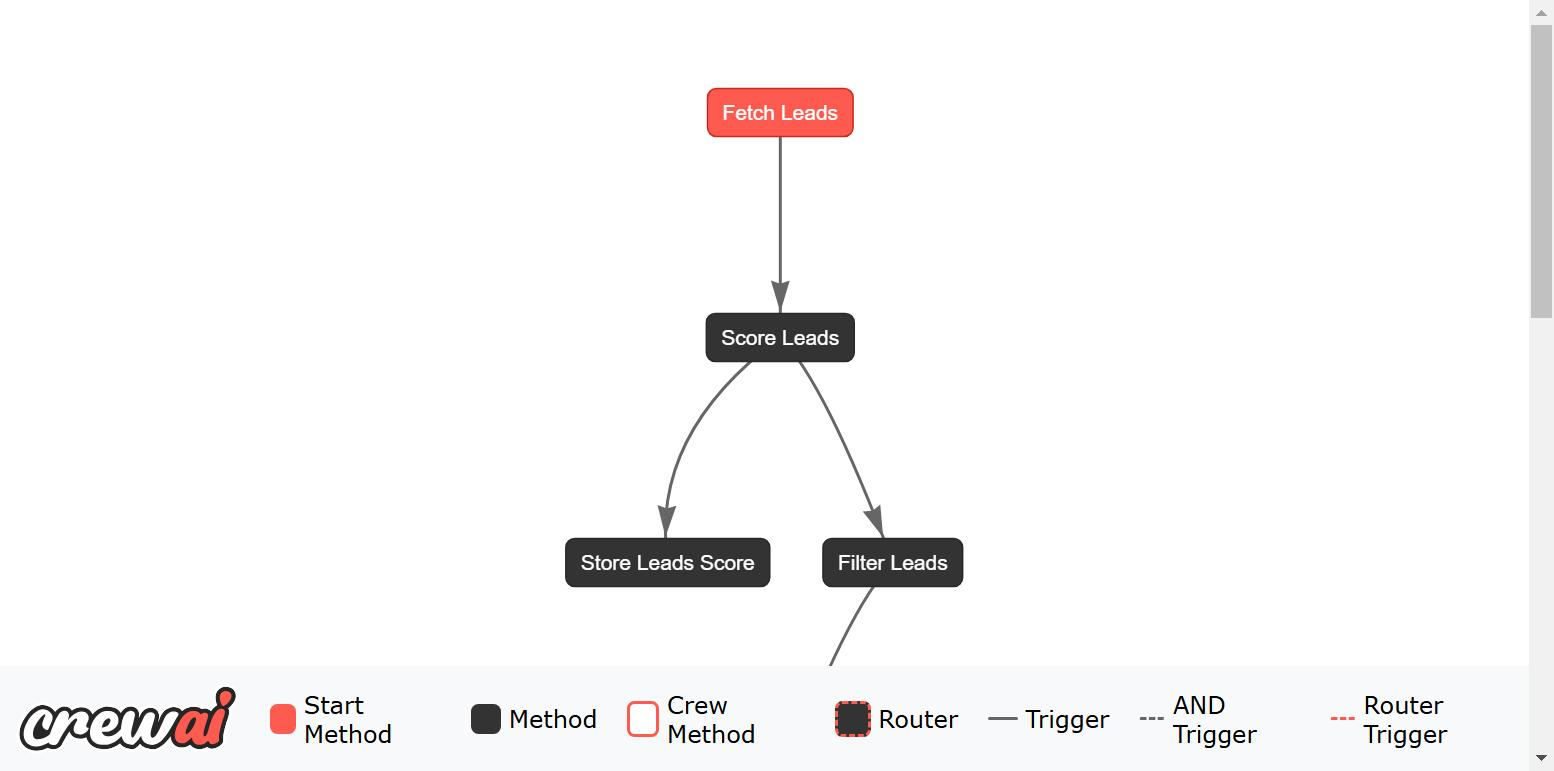

In [7]:
from IPython.display import Image

# Path to your image
image_path = 'crewai_flow.jpg'

# Display the image
Image(filename=image_path)


### Flow Kickoff

In [13]:
emails = await flow.kickoff_async()


2025-02-26 18:47:49,821 - 11928 - __init__.py-__init__:537 - WARNING: Overriding of current TracerProvider is not allowed


# Agent: Lead Data Specialist
## Task: Collect and analyze the following information about the lead:
- Personal Information:
  - Name: Obtain the full name of the lead.
  - Job Title: Determine the lead's current job title.
  - Role Relevance: Assess how relevant the lead's role is to the decision-making process on a scale from 0 to 10.
  - Professional Background: Optionally, gather a brief description of the lead's professional background.

- Company Information:
  - Company Name: Identify the name of the company the lead works for.
  - Industry: Determine the industry in which the company operates.
  - Company Size: Estimate the size of the company in terms of employee count.
  - Revenue: If available, collect information on the annual revenue of the company.
  - Market Presence: Evaluate the company's market presence on a scale from 0 to 10.

- Our Company and Product:
  - Company Name: CrewAI
  - Product: Multi-Agent Orchestration Platform
  - ICP: Enterprise companies looking int

2025-02-26 18:48:34,809 - 11928 - __init__.py-__init__:537 - WARNING: Overriding of current TracerProvider is not allowed




# Agent: Lead Scorer and Validator
## Final Answer: 
{
  "personal_info": {
    "name": "João Moura",
    "job_title": "Director of Engineering",
    "role_relevance": 8,
    "professional_background": "Typically oversees engineering teams, responsible for technology strategy, product development, and team leadership."
  },
  "company_info": {
    "company_name": "Clearbit",
    "industry": "Business/Productivity Software",
    "company_size": 139,
    "revenue": 41.6,
    "market_presence": 8
  },
  "lead_score": {
    "score": 77,
    "scoring_criteria": [
      "Role Relevance: 8",
      "Company Size: 7",
      "Market Presence: 8",
      "Cultural Fit: 8"
    ],
    "validation_notes": "Lead scored based on aligned values, industry relevance, and market impact. Strong potential for connection due to overlapping goals in technology and automation."
  }
}


# Agent: Email Content Writer
## Task: Craft a highly personalized email using the lead's name, job title, company informatio

### Usage Metrics and Costs

Let’s see how much it would cost each time if this crew runs at scale.

In [14]:
import pandas as pd

# Check if 'score_crews_results' exists in flow.state
if "score_crews_results" in flow.state:
	# Convert UsageMetrics instance to a DataFrame
	df_usage_metrics = pd.DataFrame([flow.state["score_crews_results"][0].token_usage.dict()])

	# Calculate total costs
	costs = 0.150 * df_usage_metrics['total_tokens'].sum() / 1_000_000
	print(f"Total costs: ${costs:.4f}")

	# Display the DataFrame
	df_usage_metrics
else:
	print("Key 'score_crews_results' not found in flow.state")

Total costs: $0.0034


C:\Users\Michela\AppData\Local\Temp\ipykernel_15704\2640425578.py:6: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  df_usage_metrics = pd.DataFrame([flow.state["score_crews_results"][0].token_usage.dict()])


In [15]:
import pandas as pd

# Convert UsageMetrics instance to a DataFrame
df_usage_metrics = pd.DataFrame([emails[0].token_usage.dict()])

# Calculate total costs
costs = 0.150 * df_usage_metrics['total_tokens'].sum() / 1_000_000
print(f"Total costs: ${costs:.4f}")

# Display the DataFrame
df_usage_metrics

Total costs: $0.0002


C:\Users\Michela\AppData\Local\Temp\ipykernel_15704\99626748.py:4: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  df_usage_metrics = pd.DataFrame([emails[0].token_usage.dict()])


,total_tokens,prompt_tokens,cached_prompt_tokens,completion_tokens,successful_requests
0,1174,962,0,212,2


### Inspecting Results

In [16]:
scores = flow.state["score_crews_results"]

In [17]:
import pandas as pd
from IPython.display import display, HTML

lead_scoring_result = scores[0].pydantic

# Create a dictionary with the nested structure flattened
data = {
    'Name': lead_scoring_result.personal_info.name,
    'Job Title': lead_scoring_result.personal_info.job_title,
    'Role Relevance': lead_scoring_result.personal_info.role_relevance,
    'Professional Background': lead_scoring_result.personal_info.professional_background,
    'Company Name': lead_scoring_result.company_info.company_name,
    'Industry': lead_scoring_result.company_info.industry,
    'Company Size': lead_scoring_result.company_info.company_size,
    'Revenue': lead_scoring_result.company_info.revenue,
    'Market Presence': lead_scoring_result.company_info.market_presence,
    'Lead Score': lead_scoring_result.lead_score.score,
    'Scoring Criteria': ', '.join(lead_scoring_result.lead_score.scoring_criteria),
    'Validation Notes': lead_scoring_result.lead_score.validation_notes
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(data, orient='index', columns=['Value'])

# Reset the index to turn the original column names into a regular column
df = df.reset_index()

# Rename the index column to 'Attribute'
df = df.rename(columns={'index': 'Attribute'})

# Create HTML table with bold attributes and left-aligned values
html_table = df.style.set_properties(**{'text-align': 'left'}) \
                     .format({'Attribute': lambda x: f'<b>{x}</b>'}) \
                     .hide(axis='index') \
                     .to_html()

# Display the styled HTML table
display(HTML(html_table))

Attribute,Value
Name,João Moura
Job Title,Director of Engineering
Role Relevance,8
Professional Background,"Typically oversees engineering teams, responsible for technology strategy, product development, and team leadership."
Company Name,Clearbit
Industry,Business/Productivity Software
Company Size,139
Revenue,41.600000
Market Presence,8
Lead Score,77


### Results

In [18]:
import textwrap

result_text = emails[0].raw
wrapped_text = textwrap.fill(result_text, width=80)
print(wrapped_text)

João, let's unlock new efficiencies at Clearbit with CrewAI. Our Multi-Agent
Orchestration Platform is designed to tailor AI Agent orchestration to amplify
your engineering productivity. Schedule a 15-minute call to discover how we can
quickly customize solutions that fit your needs. Click here [insert scheduling
link] to book a time that works for you. Together, we can push the boundaries of
technology strategy and improve automation in your projects. Don’t miss
out—let's get started today!


### How Complex Can it Get?

In [19]:
from crewai import Flow
from crewai.flow.flow import listen, start, and_, or_, router

class SalesPipeline(Flow):
    
  @start()
  def fetch_leads(self):
    # Pull our leads from the database
    # This is a mock, in a real-world scenario, this is where you would
    # fetch leads from a database
    leads = [
      {
        "lead_data": {
          "name": "João Moura",
          "job_title": "Director of Engineering",
          "company": "Clearbit",
          "email": "joao@clearbit.com",
          "use_case": "Using AI Agent to do better data enrichment."
        },
      },
    ]
    return leads

  @listen(fetch_leads)
  def score_leads(self, leads):
    scores = lead_scoring_crew.kickoff_for_each(leads)
    self.state["score_crews_results"] = scores
    return scores

  @listen(score_leads)
  def store_leads_score(self, scores):
    # Here we would store the scores in the database
    return scores

  @listen(score_leads)
  def filter_leads(self, scores):
    return [score for score in scores if score['lead_score'].score > 70]

  @listen(and_(filter_leads, store_leads_score))
  def log_leads(self, leads):
    print(f"Leads: {leads}")

  #@router(filter_leads, paths=["high", "medium", "low"])
  #def count_leads(self, scores):
    #if len(scores) > 10:
      #return 'high'
    #elif len(scores) > 5:
      #return 'medium'
    #else:
      #return 'low'

  @router(log_leads) # Listen to the input method
  def count_leads(self, scores):
    if len(scores) > 10:
      return 'high'
    elif len(scores) > 5:
      return 'medium'
    else:
      return 'low'

  @listen('high')
  def store_in_salesforce(self, leads):
    return leads

  @listen('medium')
  def send_to_sales_team(self, leads):
    return leads

  @listen('low')
  def write_email(self, leads):
    scored_leads = [lead.to_dict() for lead in leads]
    emails = email_writing_crew.kickoff_for_each(scored_leads)
    return emails

  @listen(write_email)
  def send_email(self, emails):
    # Here we would send the emails to the leads
    return emails

### Plotting the Flow

In [20]:
flow = SalesPipeline()
flow.plot(filename="crewai_flow_graph")


Plot saved as crewai_flow_graph.html


In [21]:
from IPython.display import IFrame

IFrame(src="http://127.0.0.1:3000/crewai_flow_graph.html", width="100%", height=600)

In [2]:
from selenium import webdriver
from PIL import Image
import time

# Set up Selenium (Ensure you have Chrome and chromedriver installed)
options = webdriver.ChromeOptions()
options.add_argument("--headless")  # Run in headless mode
options.add_argument("--disable-gpu")
options.add_argument("--window-size=1920x1080")

# Open the HTML file
driver = webdriver.Chrome(options=options)
driver.get(r"file:///C:\Users\Michela\Agentic_Sales_Pipeline\crewai_flow_graph.html")  # Update path

# Wait for rendering
time.sleep(2)

# Capture screenshot
screenshot_path = "crewai_flow_graph.png"
driver.save_screenshot(screenshot_path)
driver.quit()

# Convert to JPG
image = Image.open(screenshot_path)
image.convert("RGB").save("crewai_flow_graph.jpg", "JPEG")


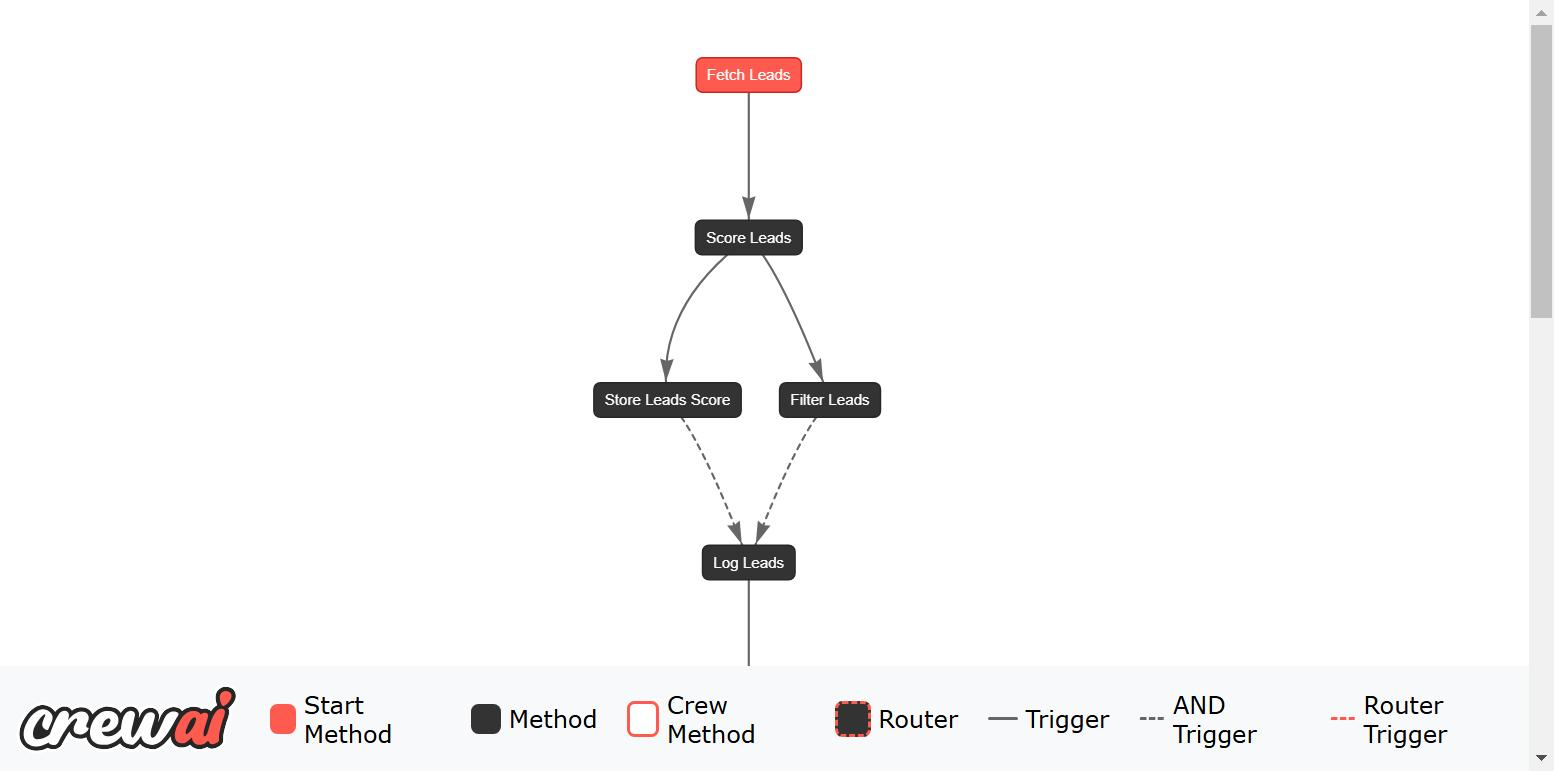

In [3]:
from IPython.display import Image

# Path to your image
image_path = 'crewai_flow_graph.jpg'

# Display the image
Image(filename=image_path)


## Conclusion
This notebook demonstrates how to set up an agentic sales pipeline using CrewAI. We created agents, tasks, and crews for both lead qualification and email engagement. By utilizing YAML configurations and Pydantic models, we ensured structured data handling. Additionally, we visualized and kicked off the sales pipeline flow. This approach can be extended and customized further for specific use cases in sales and marketing automation.

## Try It Yourself
Here are some suggestions for how you can modify this notebook to better understand and experiment with the agentic sales pipeline:

**1 Modify the Lead Data**:

- Add more leads to the fetch_leads method and observe how the pipeline processes multiple lead
- Example

In [ ]:
def fetch_leads(self):
    leads = [
        {
            "lead_data": {
                "name": "Pinco Joson",
                "job_title": "VP of Marketing",
                "company": "TechCorp",
                "email": "alice@techcorp.com",
                "use_case": "Using AI for marketing automation."
            },
        },
        {
            "lead_data": {
                "name": "Ponco Mith",
                "job_title": "CTO",
                "company": "InnovateX",
                "email": "bob@innovatex.com",
                "use_case": "Implementing AI for IT operations."
            },
        },
    ]
    return leads

**Change Scoring Criteria**:

- Modify the LeadScore model or the YAML configuration files to adjust the scoring criteria.
- Example: see example1.yaml 


**Customize Email Content**:

- Change the email drafting task configuration in the YAML files to personalize the email content based on lead data.
- Example: see example2.yaml


**Visualize Data**:

- Add a new cell to visualize the lead scoring results using graphs or charts.
- Example: see example3.yaml



In [ ]:
import matplotlib.pyplot as plt

def visualize_scores(scores):
    names = [score['personal_info']['name'] for score in scores]
    lead_scores = [score['lead_score']['score'] for score in scores]
    
    plt.figure(figsize=(10, 5))
    plt.bar(names, lead_scores, color='skyblue')
    plt.xlabel('Lead Names')
    plt.ylabel('Lead Scores')
    plt.title('Lead Scores Visualization')
    plt.show()

visualize_scores(flow.state["score_crews_results"])

Feel free to experiment with these suggestions and observe how the changes impact the overall sales pipeline.